In [116]:
import pandas as pd
import numpy as np
import math as maths
import matplotlib.pyplot as plt
import os
import seaborn as sns

usecolsResult = ["unixTimeStamp", "eventType", "keyValue", "x", "y", "offsetX", "offsetY", "keyCenterX", "keyCenterY", "holdTime", "flightTime", "pressure"]
usecolsTarget = ["eventType",  "keyValue", "offsetX", "offsetY", "keyCenterX", "keyCenterY", "holdTime", "flightTime", "pressure"]

basePath_ = "C:/Users/mathi/OneDrive/Bachelor Stuff/Studie/HauptStudie/"
basePath = "E:/OneDrive/Bachelor Stuff/Studie/HauptStudie/"

path1 = basePath + "Erster Durchlauf/KeyStrokeLog/"
path2 = basePath + "Zweiter Durchlauf/KeyStrokeLog/"

masterDFList = []
masterDFListError = []
masterDFListLikert = []

paths = [path1, path2]
for path in paths:
    targetGroupPath = path + "ID_targetValues/"

    pidList = os.listdir(path)
    pidList.remove("ID_targetValues")
    tmpResults = []
    tmpErrors = []
    tmpLikerts = []

    #One iteration = one Participant
    for pid in pidList:
        # Build filepaths for all tasks for current pid
        taskGroupPath = path + pid + "/"
        taskGroupList = os.listdir(taskGroupPath)
        taskPathDict = {}
        targetPathDict = {}
        for taskGroup in taskGroupList:
            # Filter out user created tasks
            if taskGroup != "17_user-created password":
                taskDirs = [task  for task in sorted(os.listdir(taskGroupPath + taskGroup))]
                taskPathDict[taskGroup] = [(taskGroup + "/" + taskDir)  for taskDir in taskDirs if not taskDir == "17_user-created password"]
                targetPathDict[taskGroup] = [(taskGroup + "/" + taskDir)  for taskDir in taskDirs if not taskDir == "17_user-created password"]

        # One iteration = one taskgroup
        for key in sorted(taskPathDict.keys()):
            #One iteration = one task (3 csv files per task) | (n error csv files per task)
            for task in sorted(taskPathDict[key]):
                ## 3 Valid results + target
                # last 3 csv files in <task> read as a list of dataframes
                taskResultList = [pd.read_csv(taskGroupPath + task + "/" + entry, sep=';', header=0, usecols=usecolsResult) for entry in [taskEntry for taskEntry in sorted(os.listdir(taskGroupPath + task), reverse=True) if taskEntry.startswith('valid')][:3]]
                # target df for that specific result
                targetDf = pd.read_csv(targetGroupPath + task + "/" + os.listdir(targetGroupPath + task)[0], sep=';', header=0, usecols=usecolsTarget)
                targetDf = targetDf.add_prefix('target_')
                # Combine resultDataframes with target DF (horizontally)
                for resultDf in taskResultList:
                    resultAndTargetTempDF = pd.concat([resultDf, targetDf], axis = 1)
                    resultAndTargetTempDF["task"] = task[-2:]
                    resultAndTargetTempDF["pId"] = pid
                    tmpResults.append(resultAndTargetTempDF)
                ## All invalid results
                # all error csv files in <task> read as a list of dataframes
                errorResultList = [pd.read_csv(taskGroupPath + task + "/" + entry, sep=';', header=0, usecols=usecolsResult) for entry in [taskEntry for taskEntry in sorted(os.listdir(taskGroupPath + task)) if (taskEntry.startswith('key') or taskEntry.startswith('touch'))]]
                # add pid and task info to error result dataframes
                for errorResultDf in errorResultList:
                    errorResultDf["task"] = task[-2:]
                    errorResultDf["pId"] = pid
                    tmpErrors.append(errorResultDf)
                ## All likert questions
                likertList = [pd.read_csv(taskGroupPath + task + "/" + entry, sep=';', header=0) for entry in [taskEntry for taskEntry in sorted(os.listdir(taskGroupPath + task)) if taskEntry.startswith('likert')]]
                for likertDF in likertList:
                    likertDF["task"] = task[-2:]
                    likertDF["pId"] = pid
                    tmpLikerts.append(likertDF)
    # Combine result dataframes into one big masterDF
    masterDF = pd.concat(tmpResults, axis=0)
    masterDF['area_error'] = masterDF.apply(lambda row: np.absolute(row['pressure'] - row['target_pressure']), axis=1)
    masterDF['htime_error'] = masterDF.apply(lambda row: np.absolute(row['holdTime'] - row['target_holdTime']), axis=1)
    masterDF['ftime_error'] = masterDF.apply(lambda row: np.absolute(row['flightTime'] - row['target_flightTime']), axis=1)
    masterDF['xOffset_error'] = masterDF.apply(lambda row: np.absolute(row['offsetX'] - row['target_offsetX']), axis=1)
    masterDF['yOffset_error'] = masterDF.apply(lambda row: np.absolute(row['offsetY'] - row['target_offsetY']), axis=1)
    masterDF['offset_error'] = masterDF.apply(lambda row: maths.hypot(row['offsetX'] - row['target_offsetX'], row['offsetY'] - row['target_offsetY']), axis=1)
    masterDFList.append(masterDF)
    # Combine error dataframes into one big errorMasterDF
    errorMasterDF = pd.concat(tmpErrors, axis=0)
    masterDFListError.append(errorMasterDF)
    # Combine likert dataframes into one big likertMasterDF
    likertMasterDF = pd.concat(tmpLikerts, axis=0)
    masterDFListLikert.append(likertMasterDF)
    print "Finished " + path
print "Finished"

Finished E:/OneDrive/Bachelor Stuff/Studie/HauptStudie/Erster Durchlauf/KeyStrokeLog/
Finished E:/OneDrive/Bachelor Stuff/Studie/HauptStudie/Zweiter Durchlauf/KeyStrokeLog/
Finished


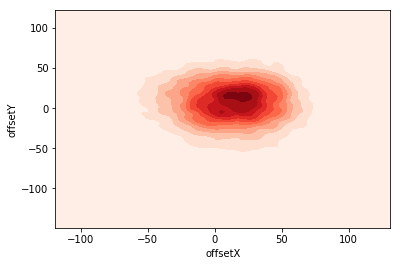

In [117]:
# Center offset contour plot 1
offsetsCenter1 = masterDFList[0][(masterDFList[0]['target_offsetX'] == 0) & (masterDFList[0]['target_offsetY'] == 0)][["offsetX", "offsetY", 'task', 'pId']]
sns.kdeplot(offsetsCenter1['offsetX'], offsetsCenter1['offsetY'], cmap="Reds", shade=True, bw=3)

In [ ]:
# Center offset contour plot 2
offsetsCenter2 = masterDFList[1][(masterDFList[1]['target_offsetX'] == 0) & (masterDFList[1]['target_offsetY'] == 0)][["offsetX", "offsetY", 'task', 'pId']]
sns.kdeplot(offsetsCenter2['offsetX'], offsetsCenter2['offsetY'], cmap="Greens", shade=True, bw=3)

In [ ]:
# Bottom offset contour plot 1
offsetsBottom1 = masterDFList[0][(masterDFList[0]['target_offsetX'] == 0) & (masterDFList[0]['target_offsetY'] == 70)][["offsetX", "offsetY", 'task', 'pId']]
offsetsBottom1['offsetY'] = offsetsBottom1.apply(lambda row: row['offsetY'] * (-1), axis=1)
ax = sns.kdeplot(offsetsBottom1['offsetX'], offsetsBottom1['offsetY'], cmap="Reds", shade=True, bw=3)
ax.set(ylim=(-100, 100))
ax.set(xlim=(-100, 100))

In [ ]:
# Bottom offset contour plot 2
offsetsBottom2 = masterDFList[1][(masterDFList[1]['target_offsetX'] == 0) & (masterDFList[1]['target_offsetY'] == 70)][["offsetX", "offsetY", 'task', 'pId']]
offsetsBottom2['offsetY'] = offsetsBottom2.apply(lambda row: row['offsetY'] * (-1), axis=1)
ax = sns.kdeplot(offsetsBottom2['offsetX'], offsetsBottom2['offsetY'], cmap="Greens", shade=True, bw=3)
ax.set(ylim=(-100, 100))
ax.set(xlim=(-100, 100))

In [ ]:
# Top offset contour plot 1
offsetsTop1 = masterDFList[0][(masterDFList[0]['target_offsetX'] == 0) & (masterDFList[0]['target_offsetY'] == -70)][["offsetX", "offsetY", 'task', 'pId']]
offsetsTop1['offsetY'] = offsetsTop1.apply(lambda row: row['offsetY'] * (-1), axis=1)
ax = sns.kdeplot(offsetsTop1['offsetX'], offsetsTop1['offsetY'], cmap="Reds", shade=True, bw=3)
ax.set(ylim=(-100, 100))
ax.set(xlim=(-100, 100))

In [ ]:
# Top offset contour plot 2
offsetsTop2 = masterDFList[1][(masterDFList[1]['target_offsetX'] == 0) & (masterDFList[1]['target_offsetY'] == -70)][["offsetX", "offsetY", 'task', 'pId']]
offsetsTop2['offsetY'] = offsetsTop2.apply(lambda row: row['offsetY'] * (-1), axis=1)
ax = sns.kdeplot(offsetsTop2['offsetX'], offsetsTop2['offsetY'], cmap="Greens", shade=True, bw=3)
ax.set(ylim=(-100, 100))
ax.set(xlim=(-100, 100))

In [ ]:
# Left offset contour plot 1
offsetsLeft1 = masterDFList[0][(masterDFList[0]['target_offsetX'] == -40) & (masterDFList[0]['target_offsetY'] == 0)][["offsetX", "offsetY", 'task', 'pId']]
ax = sns.kdeplot(offsetsLeft1['offsetX'], offsetsLeft1['offsetY'], cmap="Reds", shade=True, bw=3)
ax.set(ylim=(-100, 100))
ax.set(xlim=(-100, 100))

In [ ]:
# Left offset contour plot 2
offsetsLeft2 = masterDFList[1][(masterDFList[1]['target_offsetX'] == -40) & (masterDFList[1]['target_offsetY'] == 0)][["offsetX", "offsetY", 'task', 'pId']]
ax = sns.kdeplot(offsetsLeft2['offsetX'], offsetsLeft2['offsetY'], cmap="Greens", shade=True, bw=3)
ax.set(ylim=(-100, 100))
ax.set(xlim=(-100, 100))

In [ ]:
# Right offset contour plot 1
offsetsRigtht1 = masterDFList[0][(masterDFList[0]['target_offsetX'] == 40) & (masterDFList[0]['target_offsetY'] == 0)][["offsetX", "offsetY", 'task', 'pId']]
sns.kdeplot(offsetsRigtht1['offsetX'], offsetsRigtht1['offsetY'], cmap="Reds", shade=True, bw=3)
ax.set(ylim=(-100, 100))
ax.set(xlim=(-100, 100))

In [ ]:
# Right offset contour plot 2
offsetsRigtht2 = masterDFList[0][(masterDFList[0]['target_offsetX'] == 40) & (masterDFList[0]['target_offsetY'] == 0)][["offsetX", "offsetY", 'task', 'pId']]
sns.kdeplot(offsetsRigtht2['offsetX'], offsetsRigtht2['offsetY'], cmap="Greens", shade=True, bw=3)
ax.set(ylim=(-100, 100))
ax.set(xlim=(-100, 100))

In [ ]:
plt.figure(figsize=(12,12))
plt.xticks([-120, -100, -80, -60, -40, -20, 0, 20, 40, 60, 80, 100, 120])
plt.yticks([-120, -100, -80, -70, -60, -40, -20, 0, 20, 40, 60, 70, 80, 100, 120])

ax = sns.kdeplot(offsetsTop1['offsetX'], offsetsTop1['offsetY'], cmap="Reds", label='Bottom', shade=False, bw=7, shade_lowest=False, antialiased=True)
ax = sns.kdeplot(offsetsBottom1['offsetX'], offsetsBottom1['offsetY'], cmap="Blues", label='Right', shade=False, bw=7, shade_lowest=False, antialiased=True)
ax = sns.kdeplot(offsetsLeft1['offsetX'], offsetsLeft1['offsetY'], cmap="Purples", label='Center', shade=False, bw=7, shade_lowest=False, antialiased=True)
ax = sns.kdeplot(offsetsRigtht1['offsetX'], offsetsRigtht1['offsetY'], cmap="Oranges", label='Top', shade=False, bw=7, shade_lowest=False, antialiased=True)
ax = sns.kdeplot(offsetsCenter1['offsetX'], offsetsCenter1['offsetY'], cmap="Greens", label='Left', shade=False, bw=7, shade_lowest=False, antialiased=True)
ax.set(ylim=(-120, 120))
ax.set(xlim=(-120, 120))
plt.xlabel('Offset y [px]', fontsize=12)
plt.ylabel('Offset x [px]', fontsize=12)
ax.legend()

In [ ]:
# Offset Error
centerOffsetError1 = masterDFList[0][(masterDFList[0]['target_offsetX'] == 0) & (masterDFList[0]['target_offsetY'] == 0)][['offset_error', 'task', 'pId']]
leftOffsetError1 = masterDFList[0][(masterDFList[0]['target_offsetX'] == -40) & (masterDFList[0]['target_offsetY'] == 0)][['offset_error', 'task', 'pId']]
rightOffsetError1 = masterDFList[0][(masterDFList[0]['target_offsetX'] == 40) & (masterDFList[0]['target_offsetY'] == 0)][['offset_error', 'task', 'pId']]
topOffsetError1 = masterDFList[0][(masterDFList[0]['target_offsetX'] == 0) & (masterDFList[0]['target_offsetY'] == -70)][['offset_error', 'task', 'pId']]
bottomOffsetError1 = masterDFList[0][(masterDFList[0]['target_offsetX'] == 0) & (masterDFList[0]['target_offsetY'] == 70)][['offset_error', 'task', 'pId']]

centerOffsetError2 = masterDFList[1][(masterDFList[1]['target_offsetX'] == 0) & (masterDFList[1]['target_offsetY'] == 0)][['offset_error', 'task', 'pId']]
leftOffsetError2 = masterDFList[1][(masterDFList[1]['target_offsetX'] == -40) & (masterDFList[1]['target_offsetY'] == 0)][['offset_error', 'task', 'pId']]
rightOffsetError2 = masterDFList[1][(masterDFList[1]['target_offsetX'] == 40) & (masterDFList[1]['target_offsetY'] == 0)][['offset_error', 'task', 'pId']]
topOffsetError2 = masterDFList[1][(masterDFList[1]['target_offsetX'] == 0) & (masterDFList[1]['target_offsetY'] == -70)][['offset_error', 'task', 'pId']]
bottomOffsetError2 = masterDFList[1][(masterDFList[1]['target_offsetX'] == 0) & (masterDFList[1]['target_offsetY'] == 70)][['offset_error', 'task', 'pId']]

meanCenterOffsetError1 = centerOffsetError1['offset_error'].mean()
meanLeftOffsetError1 = leftOffsetError1['offset_error'].mean()
meanRightOffsetError1 = rightOffsetError1['offset_error'].mean()
meanTopOffsetError1 = topOffsetError1['offset_error'].mean()
meanBottomOffsetError1 = bottomOffsetError1['offset_error'].mean()

meanCenterOffsetError2 = centerOffsetError2['offset_error'].mean()
meanLeftOffsetError2 = leftOffsetError2['offset_error'].mean()
meanRightOffsetError2 = rightOffsetError2['offset_error'].mean()
meanTopOffsetError2 = topOffsetError2['offset_error'].mean()
meanBottomOffsetError2 = bottomOffsetError2['offset_error'].mean()

pCenterOffsetStd1 = centerOffsetError1.groupby('pId')['offset_error'].mean().std()
pLeftOffsetStd1 = leftOffsetError1.groupby('pId')['offset_error'].mean().std()
pRightOffsetStd1 = rightOffsetError1.groupby('pId')['offset_error'].mean().std()
pTopOffsetStd1 = topOffsetError1.groupby('pId')['offset_error'].mean().std()
pBottomOffsetStd1 = bottomOffsetError1.groupby('pId')['offset_error'].mean().std()

pCenterOffsetStd2 = centerOffsetError2.groupby('pId')['offset_error'].mean().std()
pLeftOffsetStd2 = leftOffsetError2.groupby('pId')['offset_error'].mean().std()
pRightOffsetStd2 = rightOffsetError2.groupby('pId')['offset_error'].mean().std()
pTopOffsetStd2 = topOffsetError2.groupby('pId')['offset_error'].mean().std()
pBottomOffsetStd2 = bottomOffsetError2.groupby('pId')['offset_error'].mean().std()

offset_means1 = (meanCenterOffsetError1, meanLeftOffsetError1, meanRightOffsetError1, meanTopOffsetError1, meanBottomOffsetError1)
offset_stds1 = (pCenterOffsetStd1, pLeftOffsetStd1, pRightOffsetStd1, pTopOffsetStd1, pBottomOffsetStd1)

offset_means2 = (meanCenterOffsetError2, meanLeftOffsetError2, meanRightOffsetError2, meanTopOffsetError2, meanBottomOffsetError2)
offset_stds2 = (pCenterOffsetStd2, pLeftOffsetStd2, pRightOffsetStd2, pTopOffsetStd2, pBottomOffsetStd2)

fig, ax = plt.subplots()

index = np.arange(len(offset_means1))
bar_width = 0.35

opacity = 0.4

rects1 = ax.bar(index, offset_means1, bar_width, 
               alpha=opacity, color='g', yerr=offset_stds1, label='First run')

rects2 = ax.bar(index + bar_width, offset_means2, bar_width, 
               alpha=opacity, color='b', yerr=offset_stds2, label='Second run')

ax.set_xlabel('Offset direction')
ax.set_ylabel('Avg error [px]')
ax.set_title('Offset error by offset direction')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('Center', 'Left', 'Right', 'Top', 'Bottom'))
ax.legend()

fig.tight_layout()
plt.show()

In [ ]:
# Offset error per Axis (x)
centerOffsetXError1 = masterDFList[0][(masterDFList[0]['target_offsetX'] == 0) & (masterDFList[0]['target_offsetY'] == 0)][['xOffset_error', 'task', 'pId']]
leftOffsetXError1 = masterDFList[0][(masterDFList[0]['target_offsetX'] == -40) & (masterDFList[0]['target_offsetY'] == 0)][['xOffset_error', 'task', 'pId']]
rightOffsetXError1 = masterDFList[0][(masterDFList[0]['target_offsetX'] == 40) & (masterDFList[0]['target_offsetY'] == 0)][['xOffset_error', 'task', 'pId']]
topOffsetXError1 = masterDFList[0][(masterDFList[0]['target_offsetX'] == 0) & (masterDFList[0]['target_offsetY'] == -70)][['xOffset_error', 'task', 'pId']]
bottomOffsetXError1 = masterDFList[0][(masterDFList[0]['target_offsetX'] == 0) & (masterDFList[0]['target_offsetY'] == 70)][['xOffset_error', 'task', 'pId']]

centerOffsetXError2 = masterDFList[1][(masterDFList[1]['target_offsetX'] == 0) & (masterDFList[1]['target_offsetY'] == 0)][['xOffset_error', 'task', 'pId']]
leftOffsetXError2 = masterDFList[1][(masterDFList[1]['target_offsetX'] == -40) & (masterDFList[1]['target_offsetY'] == 0)][['xOffset_error', 'task', 'pId']]
rightOffsetXError2 = masterDFList[1][(masterDFList[1]['target_offsetX'] == 40) & (masterDFList[1]['target_offsetY'] == 0)][['xOffset_error', 'task', 'pId']]
topOffsetXError2 = masterDFList[1][(masterDFList[1]['target_offsetX'] == 0) & (masterDFList[1]['target_offsetY'] == -70)][['xOffset_error', 'task', 'pId']]
bottomOffsetXError2 = masterDFList[1][(masterDFList[1]['target_offsetX'] == 0) & (masterDFList[1]['target_offsetY'] == 70)][['xOffset_error', 'task', 'pId']]

meanCenterOffsetXError1 = centerOffsetXError1['xOffset_error'].mean()
meanLeftOffsetXError1 = leftOffsetXError1['xOffset_error'].mean()
meanRightOffsetXError1 = rightOffsetXError1['xOffset_error'].mean()
meanTopOffsetXError1 = topOffsetXError1['xOffset_error'].mean()
meanBottomOffsetXError1 = bottomOffsetXError1['xOffset_error'].mean()

meanCenterOffsetXError2 = centerOffsetXError2['xOffset_error'].mean()
meanLeftOffsetXError2 = leftOffsetXError2['xOffset_error'].mean()
meanRightOffsetXError2 = rightOffsetXError2['xOffset_error'].mean()
meanTopOffsetXError2 = topOffsetXError2['xOffset_error'].mean()
meanBottomOffsetXError2 = bottomOffsetXError2['xOffset_error'].mean()

pCenterOffsetXStd1 = centerOffsetXError1.groupby('pId')['xOffset_error'].mean().std()
pLeftOffsetXStd1 = leftOffsetXError1.groupby('pId')['xOffset_error'].mean().std()
pRightOffsetXStd1 = rightOffsetXError1.groupby('pId')['xOffset_error'].mean().std()
pTopOffsetXStd1 = topOffsetXError1.groupby('pId')['xOffset_error'].mean().std()
pBottomOffsetXStd1 = bottomOffsetXError1.groupby('pId')['xOffset_error'].mean().std()

pCenterOffsetXStd2 = centerOffsetXError2.groupby('pId')['xOffset_error'].mean().std()
pLeftOffsetXStd2 = leftOffsetXError2.groupby('pId')['xOffset_error'].mean().std()
pRightOffsetXStd2 = rightOffsetXError2.groupby('pId')['xOffset_error'].mean().std()
pTopOffsetXStd2 = topOffsetXError2.groupby('pId')['xOffset_error'].mean().std()
pBottomOffsetXStd2 = bottomOffsetXError2.groupby('pId')['xOffset_error'].mean().std()

#offsetX_means1 = (meanCenterOffsetXError1, meanLeftOffsetXError1, meanRightOffsetXError1, meanTopOffsetXError1, meanBottomOffsetXError1)
#offsetX_stds1 = (pCenterOffsetXStd1, pLeftOffsetXStd1, pRightOffsetXStd1, pTopOffsetXStd1, pBottomOffsetXStd1)

offsetX_means1 = (meanLeftOffsetXError1, meanRightOffsetXError1)
offsetX_stds1 = (pLeftOffsetXStd1, pRightOffsetXStd1)

#offsetX_means2 = (meanCenterOffsetXError2, meanLeftOffsetXError2, meanRightOffsetXError2, meanTopOffsetXError2, meanBottomOffsetXError2)
#offsetX_stds2 = (pCenterOffsetXStd2, pLeftOffsetXStd2, pRightOffsetXStd2, pTopOffsetXStd2, pBottomOffsetXStd2)

offsetX_means2 = (meanLeftOffsetXError2, meanRightOffsetXError2)
offsetX_stds2 = (pLeftOffsetXStd2, pRightOffsetXStd2 )

fig, ax = plt.subplots()

index = np.arange(len(offsetX_means1))
bar_width = 0.35

opacity = 0.4

rects1 = ax.bar(index, offsetX_means1, bar_width, 
               alpha=opacity, color='g', yerr=offsetX_stds1, label='First run')

rects2 = ax.bar(index + bar_width, offsetX_means2, bar_width, 
               alpha=opacity, color='b', yerr=offsetX_stds2, label='Second run')

ax.set_xlabel('Offset direction')
ax.set_ylabel('Avg error [px]')
ax.set_title('x offset error by offset direction')
ax.set_xticks(index + bar_width / 2)
#ax.set_xticklabels(('Center', 'Left', 'Right', 'Top', 'Bottom'))
ax.set_xticklabels(('Left', 'Right'))
ax.legend()

fig.tight_layout()
plt.show()

In [ ]:
# Offset error per Axis (y)
centerOffsetYError1 = masterDFList[0][(masterDFList[0]['target_offsetX'] == 0) & (masterDFList[0]['target_offsetY'] == 0)][['yOffset_error', 'task', 'pId']]
leftOffsetYError1 = masterDFList[0][(masterDFList[0]['target_offsetX'] == -40) & (masterDFList[0]['target_offsetY'] == 0)][['yOffset_error', 'task', 'pId']]
rightOffsetYError1 = masterDFList[0][(masterDFList[0]['target_offsetX'] == 40) & (masterDFList[0]['target_offsetY'] == 0)][['yOffset_error', 'task', 'pId']]
topOffsetYError1 = masterDFList[0][(masterDFList[0]['target_offsetX'] == 0) & (masterDFList[0]['target_offsetY'] == -70)][['yOffset_error', 'task', 'pId']]
bottomOffsetYError1 = masterDFList[0][(masterDFList[0]['target_offsetX'] == 0) & (masterDFList[0]['target_offsetY'] == 70)][['yOffset_error', 'task', 'pId']]

centerOffsetYError2 = masterDFList[1][(masterDFList[1]['target_offsetX'] == 0) & (masterDFList[1]['target_offsetY'] == 0)][['yOffset_error', 'task', 'pId']]
leftOffsetYError2 = masterDFList[1][(masterDFList[1]['target_offsetX'] == -40) & (masterDFList[1]['target_offsetY'] == 0)][['yOffset_error', 'task', 'pId']]
rightOffsetYError2 = masterDFList[1][(masterDFList[1]['target_offsetX'] == 40) & (masterDFList[1]['target_offsetY'] == 0)][['yOffset_error', 'task', 'pId']]
topOffsetYError2 = masterDFList[1][(masterDFList[1]['target_offsetX'] == 0) & (masterDFList[1]['target_offsetY'] == -70)][['yOffset_error', 'task', 'pId']]
bottomOffsetYError2 = masterDFList[1][(masterDFList[1]['target_offsetX'] == 0) & (masterDFList[1]['target_offsetY'] == 70)][['yOffset_error', 'task', 'pId']]

meanCenterOffsetYError1 = centerOffsetYError1['yOffset_error'].mean()
meanLeftOffsetYError1 = leftOffsetYError1['yOffset_error'].mean()
meanRightOffsetYError1 = rightOffsetYError1['yOffset_error'].mean()
meanTopOffsetYError1 = topOffsetYError1['yOffset_error'].mean()
meanBottomOffsetYError1 = bottomOffsetYError1['yOffset_error'].mean()

meanCenterOffsetYError2 = centerOffsetYError2['yOffset_error'].mean()
meanLeftOffsetYError2 = leftOffsetYError2['yOffset_error'].mean()
meanRightOffsetYError2 = rightOffsetYError2['yOffset_error'].mean()
meanTopOffsetYError2 = topOffsetYError2['yOffset_error'].mean()
meanBottomOffsetYError2 = bottomOffsetYError2['yOffset_error'].mean()

pCenterOffsetYStd1 = centerOffsetYError1.groupby('pId')['yOffset_error'].mean().std()
pLeftOffsetYStd1 = leftOffsetYError1.groupby('pId')['yOffset_error'].mean().std()
pRightOffsetYStd1 = rightOffsetYError1.groupby('pId')['yOffset_error'].mean().std()
pTopOffsetYStd1 = topOffsetYError1.groupby('pId')['yOffset_error'].mean().std()
pBottomOffsetYStd1 = bottomOffsetYError1.groupby('pId')['yOffset_error'].mean().std()

pCenterOffsetYStd2 = centerOffsetYError2.groupby('pId')['yOffset_error'].mean().std()
pLeftOffsetYStd2 = leftOffsetYError2.groupby('pId')['yOffset_error'].mean().std()
pRightOffsetYStd2 = rightOffsetYError2.groupby('pId')['yOffset_error'].mean().std()
pTopOffsetYStd2 = topOffsetYError2.groupby('pId')['yOffset_error'].mean().std()
pBottomOffsetYStd2 = bottomOffsetYError2.groupby('pId')['yOffset_error'].mean().std()

#offsetY_means1 = (meanCenterOffsetYError1, meanLeftOffsetYError1, meanRightOffsetYError1, meanTopOffsetYError1, meanBottomOffsetYError1)
#offsetY_stds1 = (pCenterOffsetYStd1, pLeftOffsetYStd1, pRightOffsetYStd1, pTopOffsetYStd1, pBottomOffsetYStd1)

offsetY_means1 = (meanTopOffsetYError1, meanBottomOffsetYError1)
offsetY_stds1 = (pTopOffsetYStd1, pBottomOffsetYStd1)

#offsetY_means2 = (meanCenterOffsetYError2, meanLeftOffsetYError2, meanRightOffsetYError2, meanTopOffsetYError2, meanBottomOffsetYError2)
#offsetY_stds2 = (pCenterOffsetYStd2, pLeftOffsetYStd2, pRightOffsetYStd2, pTopOffsetYStd2, pBottomOffsetYStd2)

offsetY_means2 = (meanTopOffsetYError2, meanBottomOffsetYError2)
offsetY_stds2 = (pTopOffsetYStd2, pBottomOffsetYStd2)

fig, ax = plt.subplots()

index = np.arange(len(offsetY_means1))
bar_width = 0.35

opacity = 0.4

rects1 = ax.bar(index, offsetY_means1, bar_width, 
               alpha=opacity, color='g', yerr=offsetY_stds1, label='First run')

rects2 = ax.bar(index + bar_width, offsetY_means2, bar_width, 
               alpha=opacity, color='b', yerr=offsetY_stds2, label='Second run')

ax.set_xlabel('Offset direction')
ax.set_ylabel('Avg Error [px]')
ax.set_title('y offset error by offset direction')
ax.set_xticks(index + bar_width / 2)
#ax.set_xticklabels(('Center', 'Left', 'Right', 'Top', 'Bottom'))
ax.set_xticklabels(('Top', 'Bottom'))
ax.legend()

fig.tight_layout()
plt.show()

In [ ]:
# Hold time Error
defaultHoldTimeError1 = masterDFList[0][(masterDFList[0]['target_holdTime'] == 80)][['htime_error', 'task', 'pId']]
longHoldTimeError1 = masterDFList[0][(masterDFList[0]['target_holdTime'] == 300)][['htime_error', 'task', 'pId']]

defaultHoldTimeError2 = masterDFList[1][(masterDFList[1]['target_holdTime'] == 80)][['htime_error', 'task', 'pId']]
longHoldTimeError2 = masterDFList[1][(masterDFList[1]['target_holdTime'] == 300)][['htime_error', 'task', 'pId']]

meanDefaultHoldTimeError1 = defaultHoldTimeError1['htime_error'].mean()
meanLongHoldTimeError1 = longHoldTimeError1['htime_error'].mean()

meanDefaultHoldTimeError2 = defaultHoldTimeError2['htime_error'].mean()
meanLongHoldTimeError2 = longHoldTimeError2['htime_error'].mean()

pDefaultHoldTimeErrorStd1 = defaultHoldTimeError1.groupby('pId')['htime_error'].mean().std()
pLongHoldTimeErrorStd1 = longHoldTimeError1.groupby('pId')['htime_error'].mean().std()

pDefaultHoldTimeErrorStd2 = defaultHoldTimeError2.groupby('pId')['htime_error'].mean().std()
pLongHoldTimeErrorStd2 = longHoldTimeError2.groupby('pId')['htime_error'].mean().std()

holdtime_means1 = (meanDefaultHoldTimeError1, meanLongHoldTimeError1)
holdtime_stds1 = (pDefaultHoldTimeErrorStd1, pLongHoldTimeErrorStd1)

holdtime_means2 = (meanDefaultHoldTimeError2, meanLongHoldTimeError2)
holdtime_stds2 = (pDefaultHoldTimeErrorStd2, pLongHoldTimeErrorStd2)

fig, ax = plt.subplots()

index = np.arange(len(holdtime_means1))
bar_width = 0.4

opacity = 0.4

rects = ax.bar(index, holdtime_means1, bar_width, 
               alpha=opacity, color='g', yerr=holdtime_stds1, label='First run')

rects2 = ax.bar(index + bar_width, holdtime_means2, bar_width, 
               alpha=opacity, color='b', yerr=holdtime_stds2, label='Second run')

ax.set_xlabel('Hold time characteristic')
ax.set_ylabel('Avg Error [ms]')
ax.set_title('Hold time error by hold time characteristic')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('Default', 'Long'))
ax.legend()

fig.tight_layout()
plt.show()

In [ ]:
# Hold time histogram 1
x = masterDFList[0][(masterDFList[0]['target_holdTime'] == 80)][['holdTime']]
y = masterDFList[0][(masterDFList[0]['target_holdTime'] == 300)][['holdTime']]

pl1 = sns.distplot(x, label='Default');
pl2 = sns.distplot(y, label='Long')

plt.xticks([0, 80, 300, 400, 500, 1000])
pl1.set(xlim=(0, 1000))
pl2.set(xlim=(0, 1000))
plt.xlabel('Time [ms]', fontsize=12)
plt.ylabel('Distribution', fontsize=12)
plt.legend()

In [ ]:
masterDFList[0][(masterDFList[0]['target_holdTime'] == 300)][['holdTime']].describe()

In [ ]:
# Hold time histogram 2
x = masterDFList[1][(masterDFList[1]['target_holdTime'] == 80)][['holdTime']]
y = masterDFList[1][(masterDFList[1]['target_holdTime'] == 300)][['holdTime']]

pl1 = sns.distplot(x, label='Default');
pl2 = sns.distplot(y, label='Long')

plt.xticks([0, 80, 300, 400, 500, 1000])
pl1.set(xlim=(0, 1000))
pl2.set(xlim=(0, 1000))
plt.xlabel('Time [ms]', fontsize=12)
plt.ylabel('Distribution', fontsize=12)
plt.legend()

In [ ]:
masterDFList[1][(masterDFList[1]['target_holdTime'] == 300)][['holdTime']].describe()

In [ ]:
# Flight time Error
defaultFlightTimeError1 = masterDFList[0][(masterDFList[0]['target_flightTime'] == 260)][['ftime_error', 'task', 'pId']]
longFlightTimeError1 = masterDFList[0][(masterDFList[0]['target_flightTime'] == 1000)][['ftime_error', 'task', 'pId']]

defaultFlightTimeError2 = masterDFList[1][(masterDFList[1]['target_flightTime'] == 260)][['ftime_error', 'task', 'pId']]
longFlightTimeError2 = masterDFList[1][(masterDFList[1]['target_flightTime'] == 1000)][['ftime_error', 'task', 'pId']]

meanDefaultFlightTimeError1 = defaultFlightTimeError1['ftime_error'].mean()
meanLongFlightTimeError1 = longFlightTimeError1['ftime_error'].mean()

meanDefaultFlightTimeError2 = defaultFlightTimeError2['ftime_error'].mean()
meanLongFlightTimeError2 = longFlightTimeError2['ftime_error'].mean()

pDefaultFlightTimeErrorStd1 = defaultFlightTimeError1.groupby('pId')['ftime_error'].mean().std()
pLongFlightTimeErrorStd1 = longFlightTimeError1.groupby('pId')['ftime_error'].mean().std()

pDefaultFlightTimeErrorStd2 = defaultFlightTimeError2.groupby('pId')['ftime_error'].mean().std()
pLongFlightTimeErrorStd2 = longFlightTimeError2.groupby('pId')['ftime_error'].mean().std()

flighttime_means1 = (meanDefaultFlightTimeError1, meanLongFlightTimeError1)
flighttime_stds1 = (pDefaultFlightTimeErrorStd1, pLongFlightTimeErrorStd1)

flighttime_means2 = (meanDefaultFlightTimeError2, meanLongFlightTimeError2)
flighttime_stds2 = (pDefaultFlightTimeErrorStd2, pLongFlightTimeErrorStd2)

fig, ax = plt.subplots()

index = np.arange(len(flighttime_means1))
bar_width = 0.4

opacity = 0.4

rects1 = ax.bar(index, flighttime_means1, bar_width, 
               alpha=opacity, color='g', yerr=flighttime_stds1, label='First run')

rects2 = ax.bar(index + bar_width, flighttime_means2, bar_width, 
               alpha=opacity, color='b', yerr=flighttime_stds2, label='Second run')

ax.set_xlabel('Flight time characteristic')
ax.set_ylabel('Avg error [ms]')
ax.set_title('Flight time error by flight time characteristic')
ax.set_xticks(index + bar_width/2)
ax.set_xticklabels(('Default', 'Long'))
ax.legend()

fig.tight_layout()
plt.show()

In [ ]:
# Flight time histogram 1
x = masterDFList[0][(masterDFList[0]['target_flightTime'] == 260)][['flightTime']]
y = masterDFList[0][(masterDFList[0]['target_flightTime'] == 1000)][['flightTime']]

pl1 = sns.distplot(x, label='Default');
pl2 = sns.distplot(y, label='Long');

plt.xticks([0, 260, 400, 600, 800, 1000, 1500, 2000])
pl1.set(xlim=(0, 2000))
pl2.set(xlim=(0, 2000))
plt.xlabel('Time [ms]', fontsize=12)
plt.ylabel('Distribution', fontsize=12)
plt.legend()

In [ ]:
# Flight tiem histogram 2
x = masterDFList[1][(masterDFList[1]['target_flightTime'] == 260)][['flightTime']]
y = masterDFList[1][(masterDFList[1]['target_flightTime'] == 1000)][['flightTime']]

pl1 = sns.distplot(x, label='Default');
pl2 = sns.distplot(y, label='Long');

plt.xticks([0, 260, 400, 600, 800, 1000, 1500, 2000])
pl1.set(xlim=(0, 2000))
pl2.set(xlim=(0, 2000))
plt.xlabel('Time [ms]', fontsize=12)
plt.ylabel('Distribution', fontsize=12)
plt.legend()

In [ ]:
# Area Error
defaultAreaError1 = masterDFList[0][(masterDFList[0]['eventType'] == "up") & (masterDFList[0]['target_pressure'] == 0.2)][['area_error', 'task', 'pId']]
bigAreaError1 = masterDFList[0][(masterDFList[0]['eventType'] == "up") & (masterDFList[0]['target_pressure'] == 0.40)][['area_error', 'task', 'pId']]

defaultAreaError2 = masterDFList[1][(masterDFList[1]['eventType'] == "up") & (masterDFList[1]['target_pressure'] == 0.2)][['area_error', 'task', 'pId']]
bigAreaError2 = masterDFList[1][(masterDFList[1]['eventType'] == "up") & (masterDFList[1]['target_pressure'] == 0.40)][['area_error', 'task', 'pId']]

meanDefaultAreaError1 = defaultAreaError1['area_error'].mean()
meanBigAreaError1 = bigAreaError1['area_error'].mean()

meanDefaultAreaError2 = defaultAreaError2['area_error'].mean()
meanBigAreaError2 = bigAreaError2['area_error'].mean()

pDefaultAreaErrorStd1 = defaultAreaError1.groupby('pId')['area_error'].mean().std()
pBigAreaErrorStd1 = bigAreaError1.groupby('pId')['area_error'].mean().std()

pDefaultAreaErrorStd2 = defaultAreaError2.groupby('pId')['area_error'].mean().std()
pBigAreaErrorStd2 = bigAreaError2.groupby('pId')['area_error'].mean().std()

area_means1 = (meanDefaultAreaError1, meanBigAreaError1)
area_stds1 = (pDefaultAreaErrorStd1, pBigAreaErrorStd1)

area_means2 = (meanDefaultAreaError2, meanBigAreaError2)
area_stds2 = (pDefaultAreaErrorStd2, pBigAreaErrorStd2)

fig, ax = plt.subplots()

index = np.arange(len(area_means1))
bar_width = 0.4

opacity = 0.4

rects1 = ax.bar(index, area_means1, bar_width, 
               alpha=opacity, color='g', yerr=area_stds1, label='First run')

rects2 = ax.bar(index + bar_width, area_means2, bar_width, 
               alpha=opacity, color='b', yerr=area_stds2, label='Second run')

ax.set_xlabel('Area characteristic')
ax.set_ylabel('Error')
ax.set_title('Area error by area characteristic')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('Default', 'Big'))
ax.legend()

fig.tight_layout()
plt.show()

In [ ]:
# Area histogram 1
default = masterDFList[0][(masterDFList[0]['eventType'] == "up") & (masterDFList[0]['target_pressure'] == 0.2)][['pressure']]
big = masterDFList[0][(masterDFList[0]['eventType'] == "up") & (masterDFList[0]['target_pressure'] == 0.4)][['pressure']]

pl1 = sns.distplot(default, label='Default');
pl2 = sns.distplot(big, label='Big');

pl1.set(xlim=(0, 0.6))
pl2.set(xlim=(0, 0.6))
plt.xlabel('Time [ms]', fontsize=12)
plt.ylabel('Distribution', fontsize=12)
plt.legend()

In [ ]:
# Area histogram 2
default = masterDFList[1][(masterDFList[1]['eventType'] == "up") & (masterDFList[1]['target_pressure'] == 0.2)][['pressure']]
big= masterDFList[1][(masterDFList[1]['eventType'] == "up") & (masterDFList[1]['target_pressure'] == 0.4)][['pressure']]

pl3 = sns.distplot(default, label='Default')
pl4 = sns.distplot(big, label='Big')

pl3.set(xlim=(0, 0.6))
pl4.set(xlim=(0, 0.6))
plt.xlabel('Time [ms]', fontsize=12)
plt.ylabel('Distribution', fontsize=12)
plt.legend()

In [ ]:
# Center offset contour plot default behavior
offsets1 = masterDFList[0][(masterDFList[0]['target_offsetX'] == 0) & (masterDFList[0]['target_offsetY'] == 0) & (masterDFList[0]['task'] == '01')][["offsetX", "offsetY", 'task', 'pId']]
sns.kdeplot(offsets1['offsetX'], offsets1['offsetY'], cmap="Reds", shade=True, bw=3)

In [ ]:
# Hold time histogram default behavior
x = masterDFList[0][(masterDFList[0]['target_holdTime'] == 80) & (masterDFList[0]['task'] == '01')][['holdTime']]

pl1 = sns.distplot(x);

In [ ]:
# Flight time histogram default behavior
x = masterDFList[0][(masterDFList[0]['target_flightTime'] == 260) & (masterDFList[0]['task'] == '01')][['flightTime']]

pl1 = sns.distplot(x);

In [ ]:
# Flight time by double letter/ not double letter
x = masterDFList[0][(masterDFList[0]['target_flightTime'] == 260) & (masterDFList[0]['task'] == '01') ][['unixTimeStamp', 'flightTime', 'keyValue']].reset_index(drop=True)
y = x[(x['keyValue'] == 'l') | (x['keyValue'] == 's') | (x['keyValue'] == 'o')][['unixTimeStamp', 'flightTime']].iloc[1::2]
x = x[['unixTimeStamp', 'flightTime']]

x = pd.concat([x, y]).drop_duplicates(keep=False, subset=['unixTimeStamp'])

x = x[['flightTime']]
y = y[['flightTime']]

pl1 = sns.distplot(x, label='No double letters', kde=True);
pl1 = sns.distplot(y, label='Second double letters', kde=True);
plt.xticks([0, 90, 260, 400, 600, 800])
pl1.set(xlim=(0, 800))

In [ ]:
# Area histogram defailt behavior
default = masterDFList[0][(masterDFList[0]['eventType'] == "up") & (masterDFList[0]['target_pressure'] == 0.2)  & (masterDFList[0]['task'] == '01')][['pressure']]

pl1 = sns.distplot(default);

In [ ]:
# Area histogram by keyboard side
x = masterDFList[0][(masterDFList[0]['eventType'] == "up") & (masterDFList[0]['target_pressure'] == 0.2)  & (masterDFList[0]['task'] == '01') & (masterDFList[0]['x'] > 1450/2)][['pressure']]
y = masterDFList[0][(masterDFList[0]['eventType'] == "up") & (masterDFList[0]['target_pressure'] == 0.2)  & (masterDFList[0]['task'] == '01') & (masterDFList[0]['x'] <= 1450/2)][['pressure']]

pl1 = sns.distplot(x, label='Right side', kde=True);''
pl1 = sns.distplot(y, label='Left side', kde=True);
pl1.legend()

In [ ]:
dat = masterDFList[0][(masterDFList[0]['eventType'] == "up") & (masterDFList[0]['target_pressure'] == 0.2)][['x', 'y', 'pressure']]
ax = sns.scatterplot(x='x', y="pressure", data=dat)

In [ ]:
masterDFListError[1][(masterDFListError[1]['flightTime'] == -1) & (masterDFListError[1]['eventType'] == 'down')].shape

In [ ]:
masterDFListLikert[1].shape